
# Diffusion扩散模型


关于扩散模型（Diffusion Models）有很多种理解，本案例的介绍是基于denoising diffusion probabilistic model （DDPM），DDPM已经在（无）条件图像/音频/视频生成领域取得了较多显著的成果，现有的比较受欢迎的的例子包括由OpenAI主导的[GLIDE](https://arxiv.org/abs/2112.10741)和[DALL-E 2](https://openai.com/dall-e-2/)、由海德堡大学主导的[潜在扩散](https://github.com/CompVis/latent-diffusion)和由Google Brain主导的[图像生成](https://imagen.research.google/)。

实际上生成模型的扩散概念已经在（[Sohl-Dickstein et al., 2015](https://arxiv.org/abs/1503.03585)）中介绍过。然而，直到（[Song et al., 2019](https://arxiv.org/abs/1907.05600)）（斯坦福大学）和（[Ho et al., 2020](https://arxiv.org/abs/2006.11239)）（在Google Brain）才各自独立地改进了这种方法。

本案例是在Phil Wang[基于PyTorch框架的复现](https://github.com/lucidrains/denoising-diffusion-pytorch)的基础上（而它本身又是基于[TensorFlow实现](https://github.com/hojonathanho/diffusion)），迁移到MindSpore AI框架上实现的。

![Image-1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0rc2/tutorials/application/source_zh_cn/generative/images/diffusion_1.png)

本案例中我们采用离散时间（潜在变量模型）的观点，另外，读者也可以查看有关于扩散模型的其他[几个观点](https://twitter.com/sedielem/status/1530894256168222722?s=20&t=mfv4afx1GcNQU5fZklpACw)！

## 设置运行环境

由于资源限制，需开启性能优化模式，具体设置如下参数：

 max_device_memory="2GB" : 设置设备可用的最大内存为2GB。

 mode=ms.GRAPH_MODE : 表示在GRAPH_MODE模式中运行。

 device_target="Ascend" : 表示待运行的目标设备为Ascend。

 jit_config={"jit_level":"O2"} : 编译优化级别开启极致性能优化，使用下沉的执行方式。

 ascend_config={"precision_mode":"allow_mix_precision"} : 自动混合精度，自动将部分算子的精度降低到float16或bfloat16。

In [ ]:
import mindspore as ms
ms.set_context(max_device_memory="2GB", mode=ms.GRAPH_MODE, device_target="Ascend",  jit_config={"jit_level":"O2"}, ascend_config={"precision_mode":"allow_mix_precision"})

## 导入所需的库

开始之前请确保安装并导入所需的库（假设您已经安装了MindSpore、download、dataset、matplotlib以及tqdm）。

In [1]:
import math
from functools import partial
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
from multiprocessing import cpu_count
from download import download

import mindspore.nn as nn
import mindspore.ops as ops
from mindspore import Tensor, Parameter
from mindspore import dtype as mstype
from mindspore.dataset.vision import Resize, Inter, CenterCrop, ToTensor, RandomHorizontalFlip, ToPIL
from mindspore.common.initializer import initializer
from mindspore.amp import DynamicLossScaler

ms.set_seed(0)


/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## 模型简介


### 什么是Diffusion Model？

如果将Diffusion与其他生成模型（如Normalizing Flows、GAN或VAE）进行比较，它并没有那么复杂，它们都将噪声从一些简单分布转换为数据样本，Diffusion也是从纯噪声开始通过一个神经网络学习逐步去噪，最终得到一个实际图像。
Diffusion对于图像的处理包括以下两个过程：

- 我们选择的固定（或预定义）正向扩散过程 $q$ ：它逐渐将高斯噪声添加到图像中，直到最终得到纯噪声

- 一个学习的反向去噪的扩散过程 $p_\theta$ ：通过训练神经网络从纯噪声开始逐渐对图像去噪，直到最终得到一个实际的图像

![Image-2](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0rc2/tutorials/application/source_zh_cn/generative/images/diffusion_2.png)

由 $t$ 索引的正向和反向过程都发生在某些有限时间步长 $T$（DDPM作者使用 $T=1000$）内。从$t=0$开始，在数据分布中采样真实图像 $\mathbf{x}_0$（本案例使用一张来自ImageNet的猫图像形象的展示了diffusion正向添加噪声的过程），正向过程在每个时间步长 $t$ 都从高斯分布中采样一些噪声，再添加到上一个时刻的图像中。假定给定一个足够大的 $T$ 和一个在每个时间步长添加噪声的良好时间表，您最终会在 $t=T$ 通过渐进的过程得到所谓的[各向同性的高斯分布](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic)。

### 扩散模型实现原理


#### Diffusion 前向过程

所谓前向过程，即向图片上加噪声的过程。虽然这个步骤无法做到图片生成，但这是理解diffusion model以及构建训练样本至关重要的一步。
首先我们需要一个可控的损失函数，并运用神经网络对其进行优化。

设 $q(x_0)$ 是真实数据分布，由于 $x_0 \sim q(x_0)$ ，所以我们可以从这个分布中采样以获得图像 $x_0$ 。接下来我们定义前向扩散过程 $q(x_t | x_{t-1})$ ，在前向过程中我们会根据已知的方差 ${0}<\beta_{1}<\beta_{2}< ... <\beta_{T}<{1}$ 在每个时间步长 t 添加高斯噪声，由于前向过程的每个时刻 t 只与时刻 t-1 有关，所以也可以看做马尔科夫过程：

$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I})
$$

回想一下，正态分布（也称为高斯分布）由两个参数定义：平均值 $\mu$ 和方差 $\sigma^2 \geq 0$ 。基本上，在每个时间步长 $t$ 处的产生的每个新的（轻微噪声）图像都是从条件高斯分布中绘制的，其中

$$
q(\mathbf{\mu}_t) = \sqrt{1 - \beta_t} \mathbf{x}_{t-1}
$$

我们可以通过采样 $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ 然后设置

$$
q(\mathbf{x}_t) = \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +  \sqrt{\beta_t} \mathbf{\epsilon}
$$

请注意， $\beta_t$ 在每个时间步长 $t$ （因此是下标）不是恒定的：事实上，我们定义了一个所谓的“动态方差”的方法，使得每个时间步长的 $\beta_t$ 可以是线性的、二次的、余弦的等（有点像动态学习率方法）。

因此，如果我们适当设置时间表，从 $\mathbf{x}_0$ 开始，我们最终得到 $\mathbf{x}_1,  ..., \mathbf{x}_t, ..., \mathbf{x}_T$，即随着 $t$ 的增大 $\mathbf{x}_t$ 会越来越接近纯噪声，而 $\mathbf{x}_T$ 就是纯高斯噪声。

那么，如果我们知道条件概率分布 $p(\mathbf{x}_{t-1} | \mathbf{x}_t)$ ，我们就可以反向运行这个过程：通过采样一些随机高斯噪声 $\mathbf{x}_T$，然后逐渐去噪它，最终得到真实分布 $\mathbf{x}_0$ 中的样本。但是，我们不知道条件概率分布 $p(\mathbf{x}_{t-1} | \mathbf{x}_t)$ 。这很棘手，因为需要知道所有可能图像的分布，才能计算这个条件概率。


#### Diffusion 逆向过程

为了解决上述问题，我们将利用神经网络来近似（学习）这个条件概率分布 $p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t)$ , 其中 $\theta$ 是神经网络的参数。如果说前向过程(forward)是加噪的过程，那么逆向过程(reverse)就是diffusion的去噪推断过程，而通过神经网络学习并表示 $p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t)$ 的过程就是Diffusion 逆向去噪的核心。

现在，我们知道了需要一个神经网络来学习逆向过程的（条件）概率分布。我们假设这个反向过程也是高斯的，任何高斯分布都由2个参数定义：

- 由 $\mu_\theta$ 参数化的平均值

- 由 $\mu_\theta$ 参数化的方差

综上，我们可以将逆向过程公式化为

$$
p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1};\mu_\theta(\mathbf{x}_{t},t), \Sigma_\theta (\mathbf{x}_{t},t))
$$

其中平均值和方差也取决于噪声水平 $t$ ，神经网络需要通过学习来表示这些均值和方差。

- 注意，DDPM的作者决定保持方差固定，让神经网络只学习（表示）这个条件概率分布的平均值 $\mu_\theta$ 。

- 本案例我们同样假设神经网络只需要学习（表示）这个条件概率分布的平均值 $\mu_\theta$ 。

为了导出一个目标函数来学习反向过程的平均值，作者观察到 $q$ 和 $p_\theta$ 的组合可以被视为变分自动编码器(VAE)。因此，变分下界（也称为ELBO）可用于最小化真值数据样本 $\mathbf{x}_0$ 的似然负对数（有关ELBO的详细信息，请参阅VAE论文[（Kingma等人，2013年）](https://arxiv.org/abs/1312.6114)），该过程的ELBO是每个时间步长的损失之和 $L=L_0+L_1+...+L_T$ ，其中，每项的损失 $L_t$ （除了 $L_0$ ）实际上是2个高斯分布之间的KL发散，可以明确地写为相对于均值的L2-loss!

如Sohl-Dickstein等人所示，构建Diffusion正向过程的直接结果是我们可以在条件是 $\mathbf{x}_0$ （因为高斯和也是高斯）的情况下，在任意噪声水平上采样 $\mathbf{x}_t$ ，而不需要重复应用 $q$ 去采样 $\mathbf{x}_t$ ，这非常方便。使用

$$
\\\alpha_t := 1 - \beta_t\\\\\bar{\alpha}t := \Pi_{s=1}^{t} \alpha_s\\
$$

我们就有

$$  
q(\mathbf{x}_t | \mathbf{x}_0) = \cal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1- \bar{\alpha}_t) \mathbf{I})
$$

这意味着我们可以采样高斯噪声并适当地缩放它，然后将其添加到 $\mathbf{x}_0$ 中，直接获得 $\mathbf{x}_t$ 。

请注意，$\bar{\alpha}_t$ 是已知 $\beta_t$ 方差计划的函数，因此也是已知的，可以预先计算。这允许我们在训练期间优化损失函数 $L$ 的随机项。或者换句话说，在训练期间随机采样 $t$ 并优化 $L_t$ 。

正如Ho等人所展示的那样，这种性质的另一个优点是可以重新参数化平均值，使神经网络学习（预测）构成损失的KL项中噪声的附加噪声。这意味着我们的神经网络变成了噪声预测器，而不是（直接）均值预测器。其中，平均值可以按如下方式计算：

$$ \mathbf{\mu}_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(  \mathbf{x}_t - \frac{\beta_t}{\sqrt{1- \bar{\alpha}_t}} \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \right) $$

最终的目标函数 ${L}_{t}$ 如下 （随机步长 t 由 $({\epsilon} \sim N(\mathbf{0}, \mathbf{I}))$ 给定）：

$$ \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \|^2 = \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta( \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{(1- \bar{\alpha}_t)  } \mathbf{\epsilon}, t) \|^2$$

在这里， $\mathbf{x}_0$ 是初始（真实，未损坏）图像， $\mathbf{\epsilon}$ 是在时间步长 $t$ 采样的纯噪声，$\mathbf{\epsilon}_\theta (\mathbf{x}_t, t)$是我们的神经网络。神经网络是基于真实噪声和预测高斯噪声之间的简单均方误差（MSE）进行优化的。

训练算法现在如下所示：

![Image-3](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0rc2/tutorials/application/source_zh_cn/generative/images/diffusion_3.png)

换句话说：

- 我们从真实未知和可能复杂的数据分布中随机抽取一个样本 $q(\mathbf{x}_0)$

- 我们均匀地采样$1$和$T$之间的噪声水平$t$（即，随机时间步长）

- 我们从高斯分布中采样一些噪声，并使用上面定义的属性在 $t$ 时间步上破坏输入

- 神经网络被训练以基于损坏的图像 $\mathbf{x}_t$ 来预测这种噪声，即基于已知的时间表 $\mathbf{x}_t$ 上施加的噪声

实际上，所有这些都是在批数据上使用随机梯度下降来优化神经网络完成的。

#### U-Net神经网络预测噪声

神经网络需要在特定时间步长接收带噪声的图像，并返回预测的噪声。请注意，预测噪声是与输入图像具有相同大小/分辨率的张量。因此，从技术上讲，网络接受并输出相同形状的张量。那么我们可以用什么类型的神经网络来实现呢？

这里通常使用的是非常相似的[自动编码器](https://en.wikipedia.org/wiki/Autoencoder)，您可能还记得典型的"深度学习入门"教程。自动编码器在编码器和解码器之间有一个所谓的"bottleneck"层。编码器首先将图像编码为一个称为"bottleneck"的较小的隐藏表示，然后解码器将该隐藏表示解码回实际图像。这迫使网络只保留bottleneck层中最重要的信息。

在模型结构方面，DDPM的作者选择了U-Net，出自（[Ronneberger et al.，2015](https://arxiv.org/abs/1505.04597)）（当时，它在医学图像分割方面取得了最先进的结果）。这个网络就像任何自动编码器一样，在中间由一个bottleneck组成，确保网络只学习最重要的信息。重要的是，它在编码器和解码器之间引入了残差连接，极大地改善了梯度流（灵感来自于（[He et al., 2015](https://arxiv.org/abs/1512.03385)））。

![Image-4](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0rc2/tutorials/application/source_zh_cn/generative/images/diffusion_4.jpg)

可以看出，U-Net模型首先对输入进行下采样（即，在空间分辨率方面使输入更小），之后执行上采样。

## 构建Diffusion模型

下面，我们逐步构建Diffusion模型。

首先，我们定义了一些帮助函数和类，这些函数和类将在实现神经网络时使用。

In [2]:
def rearrange(head, inputs):
    b, hc, x, y = inputs.shape
    c = hc // head
    return inputs.reshape((b, head, c, x * y))

def rsqrt(x):
    res = ops.sqrt(x)
    return ops.inv(res)

def randn_like(x, dtype=None):
    if dtype is None:
        dtype = x.dtype
    res = ops.standard_normal(x.shape).astype(dtype)
    return res

def randn(shape, dtype=None):
    if dtype is None:
        dtype = ms.float32
    res = ops.standard_normal(shape).astype(dtype)
    return res

def randint(low, high, size, dtype=ms.int32):
    res = ops.uniform(size, Tensor(low, dtype), Tensor(high, dtype), dtype=dtype)
    return res

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def _check_dtype(d1, d2):
    if ms.float32 in (d1, d2):
        return ms.float32
    if d1 == d2:
        return d1
    raise ValueError('dtype is not supported.')

class Residual(nn.Cell):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def construct(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

我们还定义了上采样和下采样操作的别名。

In [3]:
def Upsample(dim):
    return nn.Conv2dTranspose(dim, dim, 4, 2, pad_mode="pad", padding=1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, pad_mode="pad", padding=1)

### 位置向量

由于神经网络的参数在时间（噪声水平）上共享，作者使用正弦位置嵌入来编码$t$，灵感来自Transformer（[Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)）。对于批处理中的每一张图像，神经网络"知道"它在哪个特定时间步长（噪声水平）上运行。

`SinusoidalPositionEmbeddings`模块采用`(batch_size, 1)`形状的张量作为输入（即批处理中几个有噪声图像的噪声水平），并将其转换为`(batch_size, dim)`形状的张量，其中`dim`是位置嵌入的尺寸。然后，我们将其添加到每个剩余块中。

In [4]:
class SinusoidalPositionEmbeddings(nn.Cell):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = np.exp(np.arange(half_dim) * - emb)
        self.emb = Tensor(emb, ms.float32)

    def construct(self, x):
        emb = x[:, None] * self.emb[None, :]
        emb = ops.concat((ops.sin(emb), ops.cos(emb)), axis=-1)
        return emb

### ResNet/ConvNeXT块

接下来，我们定义U-Net模型的核心构建块。DDPM作者使用了一个Wide ResNet块（[Zagoruyko et al., 2016](https://arxiv.org/abs/1605.07146)），但Phil Wang决定添加ConvNeXT（[Liu et al., 2022](https://arxiv.org/abs/2201.03545)）替换ResNet，因为后者在图像领域取得了巨大成功。

在最终的U-Net架构中，可以选择其中一个或另一个，本案例选择ConvNeXT块构建U-Net模型。

In [5]:
class Block(nn.Cell):
    def __init__(self, dim, dim_out, groups=1):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, pad_mode="pad", padding=1)
        self.proj = c(dim, dim_out, 3, padding=1, pad_mode='pad')
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def construct(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ConvNextBlock(nn.Cell):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.SequentialCell(nn.GELU(), nn.Dense(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, group=dim, pad_mode="pad")
        self.net = nn.SequentialCell(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1, pad_mode="pad"),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1, pad_mode="pad"),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def construct(self, x, time_emb=None):
        h = self.ds_conv(x)
        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            condition = condition.expand_dims(-1).expand_dims(-1)
            h = h + condition

        h = self.net(h)
        return h + self.res_conv(x)

### Attention模块

接下来，我们定义Attention模块，DDPM作者将其添加到卷积块之间。Attention是著名的Transformer架构([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762))，在人工智能的各个领域都取得了巨大的成功，从NLP到[蛋白质折叠](https://www.deepmind.com/blog/alphafold-a-solution-to-a-50-year-old-grand-challenge-in-biology)。Phil Wang使用了两种注意力变体：一种是常规的multi-head self-attention（如Transformer中使用的），另一种是[LinearAttention](https://github.com/lucidrains/linear-attention-transformer)([Shen et al., 2018](https://arxiv.org/abs/1812.01243))，其时间和内存要求在序列长度上线性缩放，而不是在常规注意力中缩放。

In [6]:
class Attention(nn.Cell):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, pad_mode='valid', has_bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1, pad_mode='valid', has_bias=True)
        self.map = ops.Map()
        self.partial = ops.Partial()

    def construct(self, x):
        b, _, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, 1)
        q, k, v = self.map(self.partial(rearrange, self.heads), qkv)

        q = q * self.scale

        # 'b h d i, b h d j -> b h i j'
        sim = ops.bmm(q.swapaxes(2, 3), k)
        attn = ops.softmax(sim, axis=-1)
        # 'b h i j, b h d j -> b h i d'
        out = ops.bmm(attn, v.swapaxes(2, 3))
        out = out.swapaxes(-1, -2).reshape((b, -1, h, w))

        return self.to_out(out)


class LayerNorm(nn.Cell):
    def __init__(self, dim):
        super().__init__()
        self.g = Parameter(initializer('ones', (1, dim, 1, 1)), name='g')

    def construct(self, x):
        eps = 1e-5
        var = x.var(1, keepdims=True)
        mean = x.mean(1, keep_dims=True)
        return (x - mean) * rsqrt((var + eps)) * self.g


class LinearAttention(nn.Cell):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, pad_mode='valid', has_bias=False)

        self.to_out = nn.SequentialCell(
            nn.Conv2d(hidden_dim, dim, 1, pad_mode='valid', has_bias=True),
            LayerNorm(dim)
        )

        self.map = ops.Map()
        self.partial = ops.Partial()

    def construct(self, x):
        b, _, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, 1)
        q, k, v = self.map(self.partial(rearrange, self.heads), qkv)

        q = ops.softmax(q, -2)
        k = ops.softmax(k, -1)

        q = q * self.scale
        v = v / (h * w)

        # 'b h d n, b h e n -> b h d e'
        context = ops.bmm(k, v.swapaxes(2, 3))
        # 'b h d e, b h d n -> b h e n'
        out = ops.bmm(context.swapaxes(2, 3), q)

        out = out.reshape((b, -1, h, w))
        return self.to_out(out)

### 组归一化

DDPM作者将U-Net的卷积/注意层与群归一化（[Wu et al., 2018](https://arxiv.org/abs/1803.08494)）。下面，我们定义一个`PreNorm`类，将用于在注意层之前应用groupnorm。


In [7]:
class PreNorm(nn.Cell):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def construct(self, x):
        x = self.norm(x)
        return self.fn(x)

### 条件U-Net

我们已经定义了所有的构建块（位置嵌入、ResNet/ConvNeXT块、Attention和组归一化），现在需要定义整个神经网络了。请记住，网络 $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$ 的工作是接收一批噪声图像+噪声水平，并输出添加到输入中的噪声。

更具体的：
网络获取了一批`(batch_size, num_channels, height, width)`形状的噪声图像和一批`(batch_size, 1)`形状的噪音水平作为输入，并返回`(batch_size, num_channels, height, width)`形状的张量。

网络构建过程如下：

- 首先，将卷积层应用于噪声图像批上，并计算噪声水平的位置

- 接下来，应用一系列下采样级。每个下采样阶段由2个ResNet/ConvNeXT块 + groupnorm + attention + 残差连接 + 一个下采样操作组成

- 在网络的中间，再次应用ResNet或ConvNeXT块，并与attention交织

- 接下来，应用一系列上采样级。每个上采样级由2个ResNet/ConvNeXT块+ groupnorm + attention + 残差连接 + 一个上采样操作组成

- 最后，应用ResNet/ConvNeXT块，然后应用卷积层

最终，神经网络将层堆叠起来，就像它们是乐高积木一样。

In [8]:
class Unet(nn.Cell):
    def __init__(
            self,
            dim,
            init_dim=None,
            out_dim=None,
            dim_mults=(1, 2, 4, 8),
            channels=3,
            with_time_emb=True,
            convnext_mult=2,
    ):
        super().__init__()

        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3, pad_mode="pad", has_bias=True)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ConvNextBlock, mult=convnext_mult)

        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.SequentialCell(
                SinusoidalPositionEmbeddings(dim),
                nn.Dense(dim, time_dim),
                nn.GELU(),
                nn.Dense(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        self.downs = nn.CellList([])
        self.ups = nn.CellList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.CellList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.CellList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.SequentialCell(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def construct(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        len_h = len(h) - 1
        for block1, block2, attn, upsample in self.ups:
            x = ops.concat((x, h[len_h]), 1)
            len_h -= 1
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)
        return self.final_conv(x)

### 正向扩散

我们已经知道正向扩散过程在多个时间步长$T$中，从实际分布逐渐向图像添加噪声，根据差异计划进行正向扩散。最初的DDPM作者采用了线性时间表：

- 我们将正向过程方差设置为常数，从$\beta_1 = 10^{−4}$线性增加到$\beta_T = 0.02$。

- 但是，它在（[Nichol et al., 2021](https://arxiv.org/abs/2102.09672)）中表明，当使用余弦调度时，可以获得更好的结果。

下面，我们定义了$T$时间步的时间表。

In [9]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return np.linspace(beta_start, beta_end, timesteps).astype(np.float32)

首先，让我们使用 $T=200$ 时间步长的线性计划，并定义我们需要的 $\\β_t$ 中的各种变量，例如方差 $\bar{\alpha}_t$ 的累积乘积。下面的每个变量都只是一维张量，存储从 $t$ 到 $T$ 的值。重要的是，我们还定义了`extract`函数，它将允许我们提取一批适当的 $t$ 索引。

In [10]:
# 扩散200步
timesteps = 200

# 定义 beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# 定义 alphas
alphas = 1. - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
alphas_cumprod_prev = np.pad(alphas_cumprod[:-1], (1, 0), constant_values=1)

sqrt_recip_alphas = Tensor(np.sqrt(1. / alphas))
sqrt_alphas_cumprod = Tensor(np.sqrt(alphas_cumprod))
sqrt_one_minus_alphas_cumprod = Tensor(np.sqrt(1. - alphas_cumprod))

# 计算 q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

p2_loss_weight = (1 + alphas_cumprod / (1 - alphas_cumprod)) ** -0.
p2_loss_weight = Tensor(p2_loss_weight)

def extract(a, t, x_shape):
    b = t.shape[0]
    out = Tensor(a).gather(t, -1)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

我们将用猫图像说明如何在扩散过程的每个时间步骤中添加噪音。

In [11]:
# 下载猫猫图像
url = 'https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/image_cat.zip'
path = download(url, './', kind="zip", replace=True)


file_sizes: 100%|████████████████████████████| 174k/174k [00:00<00:00, 2.35MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


In [12]:
from PIL import Image

image = Image.open('./image_cat/jpg/000000039769.jpg')
base_width = 160
image = image.resize((base_width, int(float(image.size[1]) * float(base_width / float(image.size[0])))))
image.show()

噪声被添加到mindspore张量中，而不是Pillow图像。我们将首先定义图像转换，允许我们从PIL图像转换到mindspore张量（我们可以在其上添加噪声），反之亦然。

这些转换相当简单：我们首先通过除以$255$来标准化图像（使它们在 $[0,1]$ 范围内），然后确保它们在 $[-1, 1]$ 范围内。DPPM论文中有介绍到：

> 假设图像数据由 $\{0, 1, ... , 255\}$ 中的整数组成，线性缩放为 $[−1, 1]$ ， 这确保了神经网络反向过程在从标准正常先验 $p(\mathbf{x}_T )$开始的一致缩放输入上运行。

In [13]:
from mindspore.dataset import ImageFolderDataset

image_size = 128
transforms = [
    Resize(image_size, Inter.BILINEAR),
    CenterCrop(image_size),
    ToTensor(),
    lambda t: (t * 2) - 1
]


path = './image_cat'
dataset = ImageFolderDataset(dataset_dir=path, num_parallel_workers=cpu_count(),
                             extensions=['.jpg', '.jpeg', '.png', '.tiff'],
                             num_shards=1, shard_id=0, shuffle=False, decode=True)
dataset = dataset.project('image')
transforms.insert(1, RandomHorizontalFlip())
dataset_1 = dataset.map(transforms, 'image')
dataset_2 = dataset_1.batch(1, drop_remainder=True)
x_start = next(dataset_2.create_tuple_iterator())[0]
print(x_start.shape)

(1, 3, 128, 128)


我们还定义了反向变换，它接收一个包含 $[-1, 1]$ 中的张量，并将它们转回 PIL 图像：

In [14]:
import numpy as np

reverse_transform = [
    lambda t: (t + 1) / 2,
    lambda t: ops.permute(t, (1, 2, 0)), # CHW to HWC
    lambda t: t * 255.,
    lambda t: t.asnumpy().astype(np.uint8),
    ToPIL()
]

def compose(transform, x):
    for d in transform:
        x = d(x)
    return x

让我们验证一下：

In [15]:
reverse_image = compose(reverse_transform, x_start[0])
reverse_image.show()

我们现在可以定义前向扩散过程，如下所示：

In [16]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = randn_like(x_start)
    return (extract(sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise)

让我们在特定的时间步长上测试它：

In [17]:
def get_noisy_image(x_start, t):
    # 添加噪音
    x_noisy = q_sample(x_start, t=t)

    # 转换为 PIL 图像
    noisy_image = compose(reverse_transform, x_noisy[0])

    return noisy_image

In [18]:
# 设置 time step
t = Tensor([40])
noisy_image = get_noisy_image(x_start, t)
print(noisy_image)
noisy_image.show()

<PIL.Image.Image image mode=RGB size=128x128 at 0xE7FF10167CA0>


让我们为不同的时间步骤可视化此情况：

In [19]:
import matplotlib.pyplot as plt

def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    _, axs = plt.subplots(figsize=(200, 200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [20]:
plot([get_noisy_image(x_start, Tensor([t])) for t in [0, 50, 100, 150, 199]])

这意味着我们现在可以定义给定模型的损失函数，如下所示：

In [21]:
def p_losses(unet_model, x_start, t, noise=None):
    if noise is None:
        noise = randn_like(x_start)
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = unet_model(x_noisy, t)

    loss = nn.SmoothL1Loss()(noise, predicted_noise)# todo
    loss = loss.reshape(loss.shape[0], -1)
    loss = loss * extract(p2_loss_weight, t, loss.shape)
    return loss.mean()

`denoise_model`将是我们上面定义的U-Net。我们将在真实噪声和预测噪声之间使用Huber损失。

## 数据准备与处理

在这里我们定义一个正则数据集。数据集可以来自简单的真实数据集的图像组成，如Fashion-MNIST、CIFAR-10或ImageNet，其中线性缩放为 $[−1, 1]$ 。

每个图像的大小都会调整为相同的大小。有趣的是，图像也是随机水平翻转的。根据论文内容：我们在CIFAR10的训练中使用了随机水平翻转；我们尝试了有翻转和没有翻转的训练，并发现翻转可以稍微提高样本质量。

本实验我们选用Fashion_MNIST数据集，我们使用download下载并解压Fashion_MNIST数据集到指定路径。此数据集由已经具有相同分辨率的图像组成，即28x28。

In [22]:
# 下载MNIST数据集
url = 'https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/dataset.zip'
path = download(url, './', kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 30.9M/30.9M [00:02<00:00, 11.1MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


In [23]:
from mindspore.dataset import FashionMnistDataset

image_size = 28
channels = 1
batch_size = 16

fashion_mnist_dataset_dir = "./dataset"
dataset = FashionMnistDataset(dataset_dir=fashion_mnist_dataset_dir, usage="train", num_parallel_workers=cpu_count(), shuffle=True, num_shards=1, shard_id=0)

接下来，我们定义一个transform操作，将在整个数据集上动态应用该操作。该操作应用一些基本的图像预处理：随机水平翻转、重新调整，最后使它们的值在 $[-1,1]$ 范围内。

In [24]:
transforms = [
    RandomHorizontalFlip(),
    ToTensor(),
    lambda t: (t * 2) - 1
]


dataset = dataset.project('image')
dataset = dataset.shuffle(64)
dataset = dataset.map(transforms, 'image')
dataset = dataset.batch(16, drop_remainder=True)

In [25]:
x = next(dataset.create_dict_iterator())
print(x.keys())

dict_keys(['image'])


### 采样

由于我们将在训练期间从模型中采样（以便跟踪进度），我们定义了下面的代码。采样在本案例中总结为算法2：

![Image-5](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0rc2/tutorials/application/source_zh_cn/generative/images/diffusion_5.png)

从扩散模型生成新图像是通过反转扩散过程来实现的：我们从$T$开始，我们从高斯分布中采样纯噪声，然后使用我们的神经网络逐渐去噪（使用它所学习的条件概率），直到我们最终在时间步$t = 0$结束。如上图所示，我们可以通过使用我们的噪声预测器插入平均值的重新参数化，导出一个降噪程度较低的图像
$\mathbf{x}_{t-1 }$。请注意，方差是提前知道的。

理想情况下，我们最终会得到一个看起来像是来自真实数据分布的图像。

下面的代码实现了这一点。

In [26]:
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    posterior_variance_t = extract(posterior_variance, t, x.shape)
    noise = randn_like(x)
    return model_mean + ops.sqrt(posterior_variance_t) * noise

def p_sample_loop(model, shape):
    b = shape[0]
    # 从纯噪声开始
    img = randn(shape, dtype=None)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, ms.numpy.full((b,), i, dtype=mstype.int32), i)
        imgs.append(img.asnumpy())
    return imgs

def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

## 推理过程（从模型中采样）
加载网络模型参数文件并从模型中采样，我们可以只使用上面定义的采样函数：

In [ ]:
# 定义 Unet模型
unet_model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)

name_list = []
for (name, par) in list(unet_model.parameters_and_names()):
    name_list.append(name)
i = 0
for item in list(unet_model.trainable_params()):
    item.name = name_list[i]
    i += 1

# download ckpt
diffusion_url = "https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/cluoud_obs/main/media/examples/mindspore-courses/orange-pi-online-infer/13-Diffusion/diffusion9.ckpt"
path = "./diffusion9.ckpt"
ckpt_path = download(diffusion_url, path, replace=True)

#加载参数
parameter = ms.load_checkpoint(ckpt_path)
ms.load_param_into_net(unet_model, parameter)

# 采样1个图片
unet_model.set_train(False)
samples = sample(unet_model, image_size=image_size, batch_size=1, channels=channels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

[ERROR] CORE(348401,e7ffe4d08020,python):2024-07-27-15:51:47.137.721 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_348401/3360577342.py]
[WARNING] CORE(348401,e7ffe4d08020,python):2024-07-27-15:51:47.137.889 [mindspore/core/utils/info.cc:120] ToString] The file '/tmp/ipykernel_348401/3360577342.py' may not exists.
[ERROR] CORE(348401,e7ffe4d08020,python):2024-07-27-15:51:47.138.771 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_348401/3797039485.py]
[WARNING] CORE(348401,e7ffe4d08020,python):2024-07-27-15:51:47.138.799 [mindspore/core/utils/info.cc:120] ToString] The file '/tmp/ipykernel_348401/3797039485.py' may not exists.
[ERROR] CORE(348401,e7ffe4d08020,python):2024-07-27-15:51:47.138.839 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_348401/3797039485.py]
[WARNING] CORE(348401,e7ffe4d08020,python):2024-07-27-15:51:47.138.857 [mindspore/co

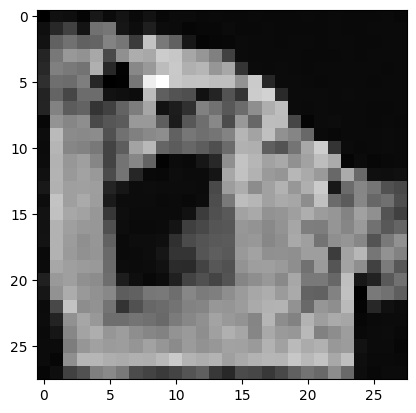

In [37]:
# 展示一个随机效果
random_index = 0
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

可以看到这个模型能产生一件衣服！

请注意，我们训练的数据集分辨率相当低（28x28）。

我们还可以创建去噪过程的gif：

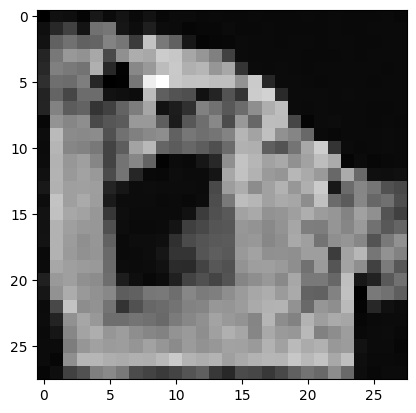

In [39]:
import matplotlib.animation as animation

random_index = 0

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=100)
animate.save('diffusion.gif')
plt.show()